In [1]:
import numpy as np
import pandas as pd

# Computes pairwise distances between design points (for LH quality)
from scipy.spatial.distance import pdist

# Statistical distributions for sampling
# Quasi-Monte Carlo tools (Latin Hypercube, Sobol sequences)

from scipy.stats import qmc, lognorm, gumbel_r, uniform # Continuous probability distributions used to map LH samples to real-valued inputs

In [2]:
# -----------------------------
# CONFIG
# -----------------------------
n = 200      # number of design points to be generated
d = 7        # number of variables
tries = 50   # number of LHS samples to evaluate

# -----------------------------
# INPUT DISTRIBUTIONS
# -----------------------------

# Lognormal: mean, std → shape (sigma), scale (exp(mu))
def get_lognormal_params(mean, std):

    sigma = np.sqrt(np.log(1 + (std / mean)**2))
    mu = np.log(mean) - 0.5 * sigma**2
    # sigma = np.log(np.sqrt(1 + (std / mean)**2))
    return sigma, np.exp(mu)            

# Gumbel: mean, std → loc, scale
def get_gumbel_params(mean, std):
    beta = std * np.sqrt(6) / np.pi   # gamma = 0.5772
    loc = mean - 0.5772 * beta # mu
    return loc, beta   # mu, beta

# Uniform: mean ± sqrt(3)*std
def get_uniform_bounds(mean, std):
    delta = np.sqrt(3) * std
    return mean - delta, mean + delta  # a, b


In [3]:
# Lognormal: mean, std → shape (sigma), scale (exp(mu))
def get_lognormal_params1(mean, std):

    sigma = np.log(np.sqrt(1 + (std / mean)**2))
    mu = np.log(mean) - 0.5 * sigma**2
    
    return sigma, np.exp(mu)   

In [4]:
get_lognormal_params1(100,22)

(np.float64(0.023632596233557204), np.float64(99.97207891842285))

In [5]:
# Lognormal: mean, std → mu, sigma
def get_lognormal_params2(mean, std):

    sigma = np.sqrt(np.log(1 + (std / mean)**2))
    mu = np.log(mean) - 0.5 * sigma**2
    return sigma, mu   

In [6]:
get_lognormal_params2(100,22)

(np.float64(0.2174055943786043), np.float64(4.581537589754535))

In [7]:
# Variable names
col_names = ['sigma_mem_y', 'sigma_mem', 'E_mem', 'sigma_edg', 'sigma_sup', 'f_mem', 'nu_mem']  # 7 x 1

# -----------------------------
# Define Lognormal Parameters
# -----------------------------

# get the parameters for each distribution and save in a dictionary 7 x 2
dist_para = {
    'sigma_mem_y': get_lognormal_params(11000, 1650), # Rupture stress  X 10^3
    'sigma_mem': get_lognormal_params(4000, 800),      # Pre-stress Membrane X 10^3
    'E_mem': get_lognormal_params(600000, 90000),   # Young's modulus X 10^6
    'sigma_edg': get_lognormal_params(353677.6513, 70735.53026), # Pre-stress Edge cables X 10^3
    'sigma_sup': get_lognormal_params(400834.6715, 80166.9343), # Pre-stress Support cables X 10^3
    'f_mem': get_gumbel_params(0.4, 0.12), # Surface load Membrane
    'nu_mem': get_uniform_bounds(0.4, 0.0115) # Poisson's ratio Membrane
}


In [8]:
dist_para


{'sigma_mem_y': (np.float64(0.14916638004195087),
  np.float64(10878.299881551278)),
 'sigma_mem': (np.float64(0.1980422004353651), np.float64(3922.3227027636817)),
 'E_mem': (np.float64(0.14916638004195087), np.float64(593361.8117209787)),
 'sigma_edg': (np.float64(0.1980422004353651), np.float64(346809.4702885319)),
 'sigma_sup': (np.float64(0.1980422004353651), np.float64(393050.7330198179)),
 'f_mem': (np.float64(0.3459950807593507), np.float64(0.09356361614804112)),
 'nu_mem': (np.float64(0.38008141571295795), np.float64(0.4199185842870421))}

In [9]:
from joblib import Parallel, delayed

# score functon to evaluate LHS samples
def lhs_score(n, d):
    sampler = qmc.LatinHypercube(d)
    sample = sampler.random(n)
    return sample, pdist(sample).min()


# parallelized LHS maximin function
def lhs_maximin_parallel(n, d, tries=50, n_jobs=-1):  # use all available cores
    results = Parallel(n_jobs=n_jobs)(  # distributes those tasks across multiple CPU cores
        delayed(lhs_score)(n, d) for _ in range(tries)  # This creates tries independent tasks
    )

    
    best_sample, best_score = max(results, key=lambda x: x[1]) # “extract the score” , # lambda = anonymous function
    return best_sample


In [10]:

# Alternative loop-based LHS maximin function
def lhs_maximin(n, d, tries=50):
    best_sample = None
    best_score = -np.inf
    
    for _ in range(tries):
        # Generate LHS sample
        sampler = qmc.LatinHypercube(d) # creates an LHS sampler in d dimensions
        
        # generates n points in [0,1]^d
        sample = sampler.random(n) # n x d array
        
        # Calculate pairwise distances to ensure Maximin criterion
        dist = pdist(sample) # n(n−1)/2 array 
        min_dist = dist.min()  # Find the smallest distance between points
        
        # Select the sample with the largest minimum distance (Maximin)
        if min_dist > best_score:
            best_score = min_dist
            best_sample = sample
    
    return best_sample


In [11]:
# Generate 200 points using LHS and Maximin criterion
X_prob = lhs_maximin_parallel(n, d, tries)  # 200 x 7 array

# 
X_phys = pd.DataFrame(X_prob, columns=col_names)

X_phys

,sigma_mem_y,sigma_mem,E_mem,sigma_edg,sigma_sup,f_mem,nu_mem
0,0.127942,0.781154,0.610197,0.251662,0.511118,0.185552,0.855499
1,0.426006,0.739482,0.739484,0.632598,0.178040,0.150764,0.901802
2,0.949854,0.453753,0.275637,0.496760,0.649879,0.379171,0.396196
3,0.581609,0.662892,0.762039,0.188459,0.777982,0.273261,0.587661
4,0.061065,0.763041,0.400499,0.821371,0.923953,0.908460,0.563946
...,...,...,...,...,...,...,...
195,0.053065,0.854560,0.072281,0.565605,0.057455,0.695837,0.056802
196,0.936512,0.351504,0.771188,0.460292,0.679736,0.069585,0.381109
197,0.024875,0.605316,0.545189,0.074000,0.730601,0.257467,0.682993
198,0.207192,0.179402,0.499370,0.503445,0.303042,0.040388,0.405895


In [12]:

# ppf : Applying Inverse CDF Transformations, probability integral transform
X_phys['sigma_mem_y'] = lognorm.ppf(X_prob[:, 0], 
                                    s=dist_para['sigma_mem_y'][0], 
                                    scale=dist_para['sigma_mem_y'][1])

X_phys['f_mem'] = gumbel_r.ppf(X_prob[:, 1], 
                               loc=dist_para['f_mem'][0], 
                               scale=dist_para['f_mem'][1])

X_phys['sigma_mem'] = lognorm.ppf(X_prob[:, 2], 
                                  s=dist_para['sigma_mem'][0], 
                                  scale=dist_para['sigma_mem'][1])

X_phys['E_mem'] = lognorm.ppf(X_prob[:, 3], 
                              s=dist_para['E_mem'][0], 
                              scale=dist_para['E_mem'][1])

X_phys['nu_mem'] = uniform.ppf(X_prob[:, 4], 
                               loc=dist_para['nu_mem'][0], 
                               scale=dist_para['nu_mem'][1])

X_phys['sigma_edg'] = lognorm.ppf(X_prob[:, 5], 
                                  s=dist_para['sigma_edg'][0], 
                                  scale=dist_para['sigma_edg'][1])

X_phys['sigma_sup'] = lognorm.ppf(X_prob[:, 6], 
                                  s=dist_para['sigma_sup'][0], 
                                  scale=dist_para['sigma_sup'][1])

In [13]:
X_phys = X_phys.round(4)  # Rounding the values for clean output
print(X_phys.head())  # Print the first 5 rows for preview

# Save the final 200-point design to a CSV file
X_phys.to_csv("lhs_maximin_sunsail_200.csv", index=False)

   sigma_mem_y  sigma_mem        E_mem    sigma_edg    sigma_sup   f_mem  \
0    9182.4214  4145.8279  536985.9637  290512.0961  484891.8386  0.4768   
1   10579.7591  4453.8937  624114.1808  282637.5777  507647.1536  0.4581   
2   13900.3747  3485.7389  592643.3121  326309.5161  373087.4755  0.3680   
3   11217.7801  4517.0719  520090.3568  307772.3000  410678.8909  0.4292   
4    8638.0321  3731.3359  680703.7506  451436.6794  405783.4684  0.4683   

   nu_mem  
0  0.5947  
1  0.4548  
2  0.6530  
3  0.7068  
4  0.7681  


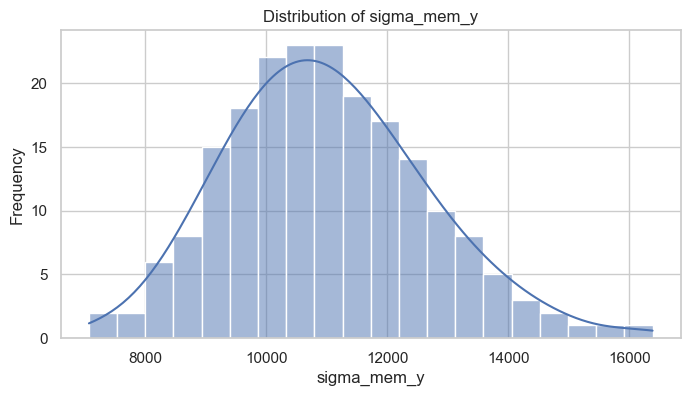

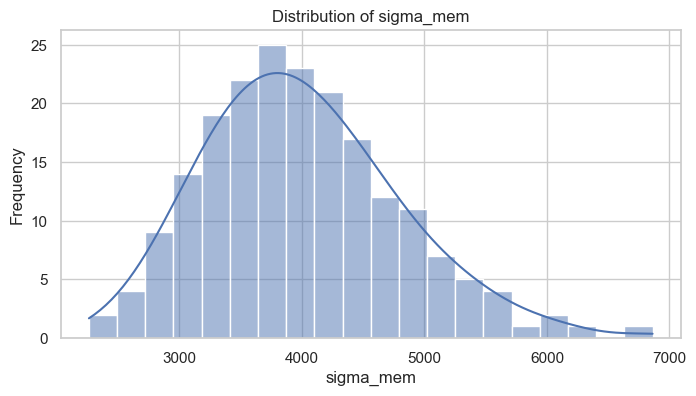

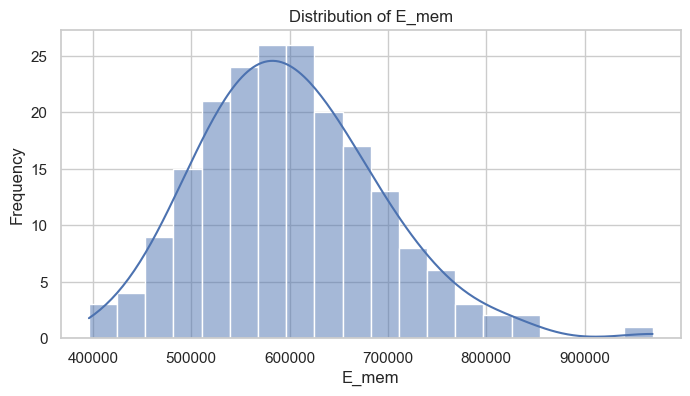

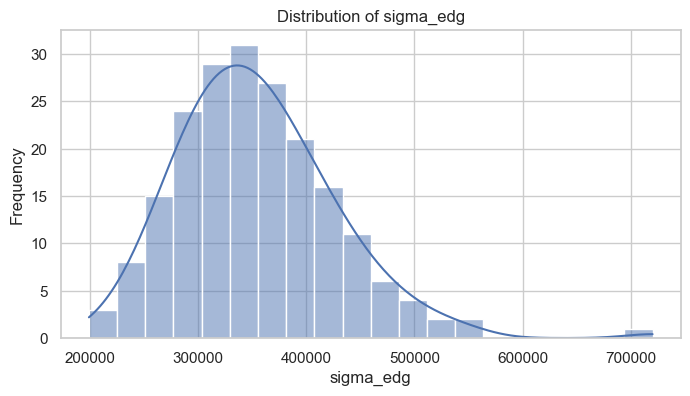

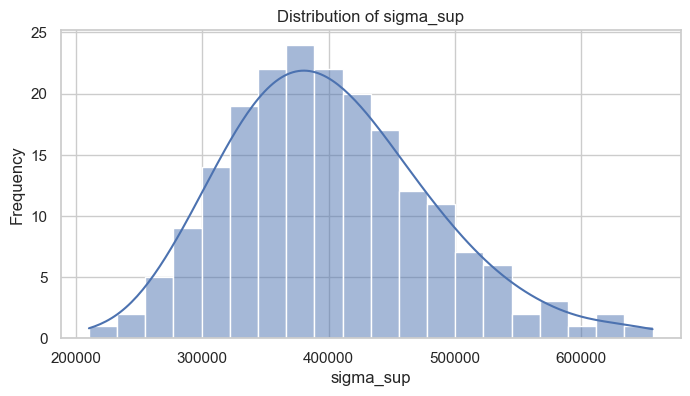

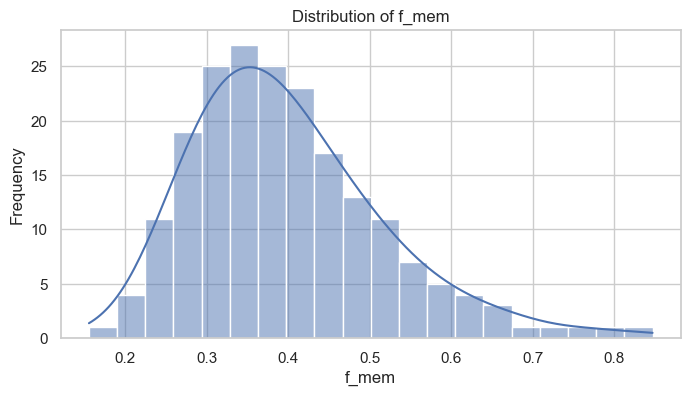

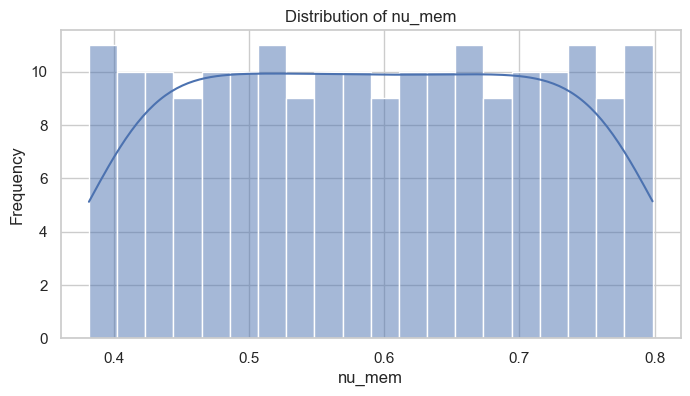

In [18]:
# Plot the histograms of the generated samples and also plot the respective PDF curves
import matplotlib.pyplot as plt
import seaborn as sns   

for col in col_names:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_phys[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()